In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

import torch
import torch.nn as nn
import torch.optim as optim

import optuna

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc,matthews_corrcoef, precision_recall_curve,roc_auc_score



データ読み取り

In [52]:
df=pd.read_csv('learning_data.csv',index_col=0)

X=df.drop(columns='dengue',axis=1).values
y=df['dengue'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1,random_state=42)

#torchテンソルに変換
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)


In [53]:
class DNN_6(nn.Module):
    def __init__(self, input_dim,dropout1,dropout2):
        super(DNN_6, self).__init__()
        self.layer1 = nn.Linear(input_dim,32)
        self.layer2 = nn.Linear(32,16)
        self.layer3 = nn.Linear(16, 8)
        self.layer4 = nn.Linear(8,4)
        self.output_layer = nn.Linear(4, 1)

        self.bn1=nn.BatchNorm1d(32)
        self.bn2=nn.BatchNorm1d(16)
        self.bn3=nn.BatchNorm1d(8)
        self.bn4=nn.BatchNorm1d(4)

        self.dropout1 = nn.Dropout(dropout1)
        self.dropout2 = nn.Dropout(dropout2)
        
    def forward(self, x):
        x = torch.relu(self.bn1(self.layer1(x)))
        x = self.dropout1(x)
        
        x = torch.relu(self.bn2(self.layer2(x)))
    

        x = torch.relu(self.bn3(self.layer3(x)))
        x = self.dropout2(x)

        x = torch.relu(self.bn4(self.layer4(x)))
        
        x = torch.sigmoid(self.output_layer(x)) 
        return x
    

学習データセットの作成

In [54]:
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=128, shuffle=False)

In [55]:
def objective(trial):
    dropout1 = trial.suggest_float("dropout1", 0, 0.5, step=0.05)
    dropout2 = trial.suggest_float("dropout2", 0, 0.5, step=0.05)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整

    # モデル定義
    model = DNN_6(
        input_dim=X_train_tensor.shape[1],
        dropout1=dropout1,
        dropout2=dropout2
    ).to(device)

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Early Stoppingの設定
    patience = 10
    best_val_loss = float('inf')
    patience_counter = 0

    # 訓練ループ
    num_epochs = 100
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch.squeeze())
            loss.backward()
            optimizer.step()

        # バリデーション評価
        model.eval()
        val_loss = 0
        val_true, val_pred = [], []
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = model(X_val).squeeze()
                val_loss += criterion(val_outputs, y_val.squeeze()).item()
                predictions = (val_outputs >=0.5).float()
                val_true.extend(y_val.cpu().numpy())
                val_pred.extend(predictions.cpu().numpy())

        val_loss /= len(val_loader)

        # Early Stoppingの判定
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

        # Optunaへのログ
        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    # 評価指標の計算
    mcc = matthews_corrcoef(val_true, val_pred)
    print(f"Final MCC: {mcc:.4f}")

    return mcc  # mccを返す


In [56]:
device_id = 0  # 使用するGPUのID（0または1）
torch.cuda.set_device(device_id)
device = torch.device(f"cuda:{device_id}" if torch.cuda.is_available() else "cpu")

# Optunaの設定
study = optuna.create_study(direction="maximize")  
study.optimize(objective, n_trials=100)

# 結果表示
print("Best Parameters: ", study.best_params)
print("Best Validation F1: ", study.best_value)

[I 2024-12-12 21:01:30,534] A new study created in memory with name: no-name-3f1a0542-4fcd-47ac-bbfe-d85125af0af1
/tmp/ipykernel_1285281/2195649114.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_1285281/2195649114.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-12 21:01:35,908] Trial 0 finished with value: 0.0 and parameters: {'dropout1': 0.45, 'dropout2': 0.25, 'learning_rate': 0.01683795591711285, 'weight_decay': 0.004784656660142866}. Best is trial 0 with value: 0.0.


Early stopping at epoch 38
Final MCC: 0.0000


/tmp/ipykernel_1285281/2195649114.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_1285281/2195649114.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-12 21:01:38,914] Trial 1 finished with value: 0.09972557820171411 and parameters: {'dropout1': 0.4, 'dropout2': 0.0, 'learning_rate': 0.01607541872841226, 'weight_decay': 6.975476992926437e-05}. Best is trial 1 with value: 0.09972557820171411.


Early stopping at epoch 21
Final MCC: 0.0997


/tmp/ipykernel_1285281/2195649114.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_1285281/2195649114.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-12 21:01:46,327] Trial 2 finished with value: 0.21167785409592751 and parameters: {'dropout1': 0.2, 'dropout2': 0.45, 'learning_rate': 0.0011029044260769596, 'weight_decay': 0.017040998020995065}. Best is trial 2 with value: 0.21167785409592751.


Early stopping at epoch 53
Final MCC: 0.2117


/tmp/ipykernel_1285281/2195649114.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_1285281/2195649114.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-12 21:01:52,343] Trial 3 finished with value: 0.2253425835243262 and parameters: {'dropout1': 0.05, 'dropout2': 0.25, 'learning_rate': 0.0006050156111429414, 'weight_decay': 0.0005206687189751427}. Best is trial 3 with value: 0.2253425835243262.


Early stopping at epoch 43
Final MCC: 0.2253


/tmp/ipykernel_1285281/2195649114.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_1285281/2195649114.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-12 21:01:59,028] Trial 4 finished with value: 0.18285714285714286 and parameters: {'dropout1': 0.05, 'dropout2': 0.1, 'learning_rate': 0.0003738514609695898, 'weight_decay': 1.477463450895148e-05}. Best is trial 3 with value: 0.2253425835243262.
/tmp/ipykernel_1285281/2195649114.py:4: FutureWarning: suggest_loguniform has been deprecate

Early stopping at epoch 49
Final MCC: 0.1829


[I 2024-12-12 21:01:59,335] Trial 6 pruned. 
[I 2024-12-12 21:01:59,479] Trial 7 pruned. 
[I 2024-12-12 21:02:05,845] Trial 8 finished with value: 0.06986653107724576 and parameters: {'dropout1': 0.1, 'dropout2': 0.5, 'learning_rate': 0.0008578798704694724, 'weight_decay': 0.05149870992773073}. Best is trial 3 with value: 0.2253425835243262.
/tmp/ipykernel_1285281/2195649114.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_1285281/2195649114.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 20

Early stopping at epoch 46
Final MCC: 0.0699


[I 2024-12-12 21:02:18,270] Trial 10 finished with value: 0.16469315538757745 and parameters: {'dropout1': 0.0, 'dropout2': 0.15000000000000002, 'learning_rate': 0.0001110656953550572, 'weight_decay': 0.0002693998084069984}. Best is trial 3 with value: 0.2253425835243262.


Early stopping at epoch 90
Final MCC: 0.1647


/tmp/ipykernel_1285281/2195649114.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_1285281/2195649114.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-12 21:02:24,114] Trial 11 finished with value: 0.1981107909197888 and parameters: {'dropout1': 0.15000000000000002, 'dropout2': 0.45, 'learning_rate': 0.0015616774937329556, 'weight_decay': 0.0007023077278952505}. Best is trial 3 with value: 0.2253425835243262.
/tmp/ipykernel_1285281/2195649114.py:4: FutureWarning: suggest_loguniform ha

Early stopping at epoch 41
Final MCC: 0.1981


[I 2024-12-12 21:02:24,466] Trial 13 pruned. 
[I 2024-12-12 21:02:24,654] Trial 14 pruned. 
[I 2024-12-12 21:02:24,811] Trial 15 pruned. 
[I 2024-12-12 21:02:24,973] Trial 16 pruned. 
[I 2024-12-12 21:02:25,146] Trial 17 pruned. 
[I 2024-12-12 21:02:25,312] Trial 18 pruned. 
[I 2024-12-12 21:02:25,503] Trial 19 pruned. 
[I 2024-12-12 21:02:25,672] Trial 20 pruned. 
[I 2024-12-12 21:02:30,981] Trial 21 finished with value: 0.2006979507182985 and parameters: {'dropout1': 0.15000000000000002, 'dropout2': 0.45, 'learning_rate': 0.0016653208754423413, 'weight_decay': 0.00035040005606920175}. Best is trial 3 with value: 0.2253425835243262.
/tmp/ipykernel_1285281/2195649114.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_1285281/219564911

Early stopping at epoch 38
Final MCC: 0.2007


[I 2024-12-12 21:02:31,324] Trial 23 pruned. 
[I 2024-12-12 21:02:31,496] Trial 24 pruned. 
[I 2024-12-12 21:02:31,660] Trial 25 pruned. 
[I 2024-12-12 21:02:31,851] Trial 26 pruned. 
[I 2024-12-12 21:02:38,751] Trial 27 finished with value: 0.19752488647727628 and parameters: {'dropout1': 0.25, 'dropout2': 0.5, 'learning_rate': 0.0024926905939034673, 'weight_decay': 0.0001722785819207004}. Best is trial 3 with value: 0.2253425835243262.
/tmp/ipykernel_1285281/2195649114.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_1285281/2195649114.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=Tr

Early stopping at epoch 50
Final MCC: 0.1975


[I 2024-12-12 21:02:39,105] Trial 29 pruned. 
[I 2024-12-12 21:02:44,692] Trial 30 finished with value: 0.20155811598048665 and parameters: {'dropout1': 0.2, 'dropout2': 0.25, 'learning_rate': 0.0010928858792809057, 'weight_decay': 0.010679656136870037}. Best is trial 3 with value: 0.2253425835243262.
/tmp/ipykernel_1285281/2195649114.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_1285281/2195649114.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-12 21:02:44,872] Trial 31 pruned. 


Early stopping at epoch 40
Final MCC: 0.2016


[I 2024-12-12 21:02:45,046] Trial 32 pruned. 
[I 2024-12-12 21:02:55,078] Trial 33 finished with value: -0.020498001542269693 and parameters: {'dropout1': 0.25, 'dropout2': 0.30000000000000004, 'learning_rate': 0.00038826311970261275, 'weight_decay': 0.045396363294932816}. Best is trial 3 with value: 0.2253425835243262.
/tmp/ipykernel_1285281/2195649114.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_1285281/2195649114.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-12 21:02:55,243]

Early stopping at epoch 73
Final MCC: -0.0205


[I 2024-12-12 21:02:55,408] Trial 35 pruned. 
[I 2024-12-12 21:02:55,597] Trial 36 pruned. 
[I 2024-12-12 21:02:55,758] Trial 37 pruned. 
[I 2024-12-12 21:02:55,938] Trial 38 pruned. 
[I 2024-12-12 21:02:56,102] Trial 39 pruned. 
[I 2024-12-12 21:02:56,255] Trial 40 pruned. 
[I 2024-12-12 21:02:56,417] Trial 41 pruned. 
[I 2024-12-12 21:03:01,840] Trial 42 finished with value: 0.11073664488434595 and parameters: {'dropout1': 0.25, 'dropout2': 0.5, 'learning_rate': 0.0008847169550095093, 'weight_decay': 0.0007399069168938951}. Best is trial 3 with value: 0.2253425835243262.
/tmp/ipykernel_1285281/2195649114.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_1285281/2195649114.py:5: FutureWarning: suggest_loguniform has been deprecated 

Early stopping at epoch 40
Final MCC: 0.1107


[I 2024-12-12 21:03:02,191] Trial 44 pruned. 
[I 2024-12-12 21:03:06,779] Trial 45 finished with value: 0.12866309174879753 and parameters: {'dropout1': 0.30000000000000004, 'dropout2': 0.35000000000000003, 'learning_rate': 0.0016065374997485, 'weight_decay': 0.009972253445082763}. Best is trial 3 with value: 0.2253425835243262.
/tmp/ipykernel_1285281/2195649114.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_1285281/2195649114.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-12 21:0

Early stopping at epoch 34
Final MCC: 0.1287


[I 2024-12-12 21:03:07,072] Trial 47 pruned. 
[I 2024-12-12 21:03:15,486] Trial 48 finished with value: 0.09311575134142959 and parameters: {'dropout1': 0.15000000000000002, 'dropout2': 0.35000000000000003, 'learning_rate': 0.0007588118088421798, 'weight_decay': 0.017631602165295204}. Best is trial 3 with value: 0.2253425835243262.
/tmp/ipykernel_1285281/2195649114.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_1285281/2195649114.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-12 2

Early stopping at epoch 62
Final MCC: 0.0931


[I 2024-12-12 21:03:25,868] Trial 50 finished with value: 0.22021303264001046 and parameters: {'dropout1': 0.0, 'dropout2': 0.4, 'learning_rate': 0.00030106870157138235, 'weight_decay': 0.00038047422743411863}. Best is trial 3 with value: 0.2253425835243262.


Early stopping at epoch 76
Final MCC: 0.2202


/tmp/ipykernel_1285281/2195649114.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_1285281/2195649114.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-12 21:03:35,911] Trial 51 finished with value: 0.23456648721306436 and parameters: {'dropout1': 0.0, 'dropout2': 0.4, 'learning_rate': 0.0002629863626109198, 'weight_decay': 0.00037853668743634907}. Best is trial 51 with value: 0.23456648721306436.
/tmp/ipykernel_1285281/2195649114.py:4: FutureWarning: suggest_loguniform has been deprec

Early stopping at epoch 77
Final MCC: 0.2346


[I 2024-12-12 21:03:36,286] Trial 53 pruned. 
[I 2024-12-12 21:03:36,456] Trial 54 pruned. 
[I 2024-12-12 21:03:36,619] Trial 55 pruned. 
[I 2024-12-12 21:03:41,404] Trial 56 finished with value: 0.2505981300796612 and parameters: {'dropout1': 0.0, 'dropout2': 0.30000000000000004, 'learning_rate': 0.0005031487583495494, 'weight_decay': 0.0009531416398357554}. Best is trial 56 with value: 0.2505981300796612.
/tmp/ipykernel_1285281/2195649114.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_1285281/2195649114.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = t

Early stopping at epoch 35
Final MCC: 0.2506


[I 2024-12-12 21:03:41,746] Trial 58 pruned. 
[I 2024-12-12 21:03:41,939] Trial 59 pruned. 
[I 2024-12-12 21:03:42,107] Trial 60 pruned. 
[I 2024-12-12 21:03:55,593] Trial 61 finished with value: 0.16061237167872047 and parameters: {'dropout1': 0.05, 'dropout2': 0.45, 'learning_rate': 0.0001424561997665493, 'weight_decay': 0.0009035087345693045}. Best is trial 56 with value: 0.2505981300796612.


Final MCC: 0.1606


/tmp/ipykernel_1285281/2195649114.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_1285281/2195649114.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-12 21:04:08,751] Trial 62 finished with value: 0.2491270510681658 and parameters: {'dropout1': 0.1, 'dropout2': 0.4, 'learning_rate': 0.0002354854665453752, 'weight_decay': 0.0003777272803730575}. Best is trial 56 with value: 0.2505981300796612.


Final MCC: 0.2491


/tmp/ipykernel_1285281/2195649114.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_1285281/2195649114.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-12 21:04:20,479] Trial 63 finished with value: 0.23969851967409345 and parameters: {'dropout1': 0.1, 'dropout2': 0.35000000000000003, 'learning_rate': 0.00033389792995967875, 'weight_decay': 0.0006667854225254814}. Best is trial 56 with value: 0.2505981300796612.


Early stopping at epoch 85
Final MCC: 0.2397


/tmp/ipykernel_1285281/2195649114.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_1285281/2195649114.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-12 21:04:33,606] Trial 64 finished with value: 0.19245008972987526 and parameters: {'dropout1': 0.1, 'dropout2': 0.4, 'learning_rate': 0.00026474947717469125, 'weight_decay': 0.00027339035689474275}. Best is trial 56 with value: 0.2505981300796612.


Early stopping at epoch 97
Final MCC: 0.1925


/tmp/ipykernel_1285281/2195649114.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_1285281/2195649114.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-12 21:04:47,042] Trial 65 finished with value: 0.2820380374088831 and parameters: {'dropout1': 0.05, 'dropout2': 0.35000000000000003, 'learning_rate': 0.0001037074018757262, 'weight_decay': 0.0007126637506587911}. Best is trial 65 with value: 0.2820380374088831.
/tmp/ipykernel_1285281/2195649114.py:4: FutureWarning: suggest_loguniform h

Final MCC: 0.2820


[I 2024-12-12 21:05:00,484] Trial 67 finished with value: 0.3519296838064799 and parameters: {'dropout1': 0.0, 'dropout2': 0.35000000000000003, 'learning_rate': 0.00011649952740879514, 'weight_decay': 0.0004698019738116687}. Best is trial 67 with value: 0.3519296838064799.
/tmp/ipykernel_1285281/2195649114.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_1285281/2195649114.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-12 21:05:00,654] Trial 68 pruned. 


Final MCC: 0.3519


[I 2024-12-12 21:05:00,820] Trial 69 pruned. 
[I 2024-12-12 21:05:02,247] Trial 70 finished with value: 0.26970669762114313 and parameters: {'dropout1': 0.0, 'dropout2': 0.30000000000000004, 'learning_rate': 0.00014593789514500457, 'weight_decay': 0.0003090296919446039}. Best is trial 67 with value: 0.3519296838064799.


Early stopping at epoch 10
Final MCC: 0.2697


/tmp/ipykernel_1285281/2195649114.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_1285281/2195649114.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-12 21:05:15,321] Trial 71 finished with value: 0.15952463458184282 and parameters: {'dropout1': 0.0, 'dropout2': 0.30000000000000004, 'learning_rate': 0.00015306323029791406, 'weight_decay': 0.0005068329088081467}. Best is trial 67 with value: 0.3519296838064799.


Final MCC: 0.1595


/tmp/ipykernel_1285281/2195649114.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_1285281/2195649114.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-12 21:05:28,311] Trial 72 finished with value: 0.16022142494441605 and parameters: {'dropout1': 0.0, 'dropout2': 0.30000000000000004, 'learning_rate': 0.00012815196698024925, 'weight_decay': 0.00029790993828445584}. Best is trial 67 with value: 0.3519296838064799.
/tmp/ipykernel_1285281/2195649114.py:4: FutureWarning: suggest_loguniform

Final MCC: 0.1602


[I 2024-12-12 21:05:41,899] Trial 74 finished with value: 0.3466162967069742 and parameters: {'dropout1': 0.1, 'dropout2': 0.30000000000000004, 'learning_rate': 0.0002237500328597118, 'weight_decay': 0.0006303450334521479}. Best is trial 67 with value: 0.3519296838064799.
/tmp/ipykernel_1285281/2195649114.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_1285281/2195649114.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-12 21:05:42,054] Trial 75 pruned. 


Final MCC: 0.3466


[I 2024-12-12 21:05:42,221] Trial 76 pruned. 
[I 2024-12-12 21:05:55,468] Trial 77 finished with value: 0.20599826550471345 and parameters: {'dropout1': 0.05, 'dropout2': 0.4, 'learning_rate': 0.00012370918787220047, 'weight_decay': 0.0008913374849679078}. Best is trial 67 with value: 0.3519296838064799.
/tmp/ipykernel_1285281/2195649114.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_1285281/2195649114.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-12 21:05:55,593] Trial 78 pruned

Final MCC: 0.2060


[I 2024-12-12 21:05:55,717] Trial 79 pruned. 
[I 2024-12-12 21:06:04,394] Trial 80 finished with value: 0.15348397985425583 and parameters: {'dropout1': 0.0, 'dropout2': 0.30000000000000004, 'learning_rate': 0.0003296896784989757, 'weight_decay': 0.0003167076885655517}. Best is trial 67 with value: 0.3519296838064799.
/tmp/ipykernel_1285281/2195649114.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_1285281/2195649114.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-12 21:06:04,566] T

Early stopping at epoch 64
Final MCC: 0.1535


[I 2024-12-12 21:06:04,739] Trial 82 pruned. 
[I 2024-12-12 21:06:04,895] Trial 83 pruned. 
[I 2024-12-12 21:06:14,615] Trial 84 finished with value: 0.18043743550526925 and parameters: {'dropout1': 0.0, 'dropout2': 0.4, 'learning_rate': 0.0003660035031549009, 'weight_decay': 0.0010267104178222509}. Best is trial 67 with value: 0.3519296838064799.


Early stopping at epoch 72
Final MCC: 0.1804


/tmp/ipykernel_1285281/2195649114.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_1285281/2195649114.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-12 21:06:28,101] Trial 85 finished with value: 0.29820711911014497 and parameters: {'dropout1': 0.45, 'dropout2': 0.30000000000000004, 'learning_rate': 0.00020742452527433268, 'weight_decay': 0.00040202510145417294}. Best is trial 67 with value: 0.3519296838064799.


Final MCC: 0.2982


/tmp/ipykernel_1285281/2195649114.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_1285281/2195649114.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-12 21:06:41,532] Trial 86 finished with value: 0.06683528052994064 and parameters: {'dropout1': 0.45, 'dropout2': 0.30000000000000004, 'learning_rate': 0.00020052960684858854, 'weight_decay': 0.00022901721948393383}. Best is trial 67 with value: 0.3519296838064799.
/tmp/ipykernel_1285281/2195649114.py:4: FutureWarning: suggest_logunifor

Final MCC: 0.0668


[I 2024-12-12 21:06:55,251] Trial 88 finished with value: 0.2336269260954477 and parameters: {'dropout1': 0.35000000000000003, 'dropout2': 0.30000000000000004, 'learning_rate': 0.00015616357535195636, 'weight_decay': 0.0008196930412739763}. Best is trial 67 with value: 0.3519296838064799.


Final MCC: 0.2336


/tmp/ipykernel_1285281/2195649114.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_1285281/2195649114.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-12 21:07:08,661] Trial 89 finished with value: 0.3262076873547043 and parameters: {'dropout1': 0.0, 'dropout2': 0.4, 'learning_rate': 0.000267100442732523, 'weight_decay': 0.0027127248233380524}. Best is trial 67 with value: 0.3519296838064799.
/tmp/ipykernel_1285281/2195649114.py:4: FutureWarning: suggest_loguniform has been deprecated

Final MCC: 0.3262


[I 2024-12-12 21:07:09,010] Trial 91 pruned. 
[I 2024-12-12 21:07:17,526] Trial 92 finished with value: 0.20855180581096214 and parameters: {'dropout1': 0.0, 'dropout2': 0.35000000000000003, 'learning_rate': 0.00033542689704526137, 'weight_decay': 0.001146382054508072}. Best is trial 67 with value: 0.3519296838064799.
/tmp/ipykernel_1285281/2195649114.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_1285281/2195649114.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)   # 範囲を調整
[I 2024-12-12 21:07:17,638] T

Early stopping at epoch 67
Final MCC: 0.2086


[I 2024-12-12 21:07:17,776] Trial 94 pruned. 
[I 2024-12-12 21:07:17,906] Trial 95 pruned. 
[I 2024-12-12 21:07:30,470] Trial 96 finished with value: 0.18850975507974496 and parameters: {'dropout1': 0.0, 'dropout2': 0.35000000000000003, 'learning_rate': 0.00023729564796997664, 'weight_decay': 0.0029369614226196295}. Best is trial 67 with value: 0.3519296838064799.
/tmp/ipykernel_1285281/2195649114.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)  # 範囲を調整
/tmp/ipykernel_1285281/2195649114.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5

Final MCC: 0.1885


[I 2024-12-12 21:07:30,758] Trial 98 pruned. 
[I 2024-12-12 21:07:30,924] Trial 99 pruned. 


Best Parameters:  {'dropout1': 0.0, 'dropout2': 0.35000000000000003, 'learning_rate': 0.00011649952740879514, 'weight_decay': 0.0004698019738116687}
Best Validation F1:  0.3519296838064799


In [57]:
best_params = study.best_params

# JSON形式で保存
with open("optim_param/optim_DNN_6_params.json", "w") as f:
    json.dump(best_params, f)

print("Best parameters saved to 'best_params.json'")

Best parameters saved to 'best_params.json'


Epoch [1/80], Loss: 0.7829
Epoch [1/80], Train Loss: 0.7829, Val Loss: 0.7487
Epoch [2/80], Loss: 0.7748
Epoch [2/80], Train Loss: 0.7748, Val Loss: 0.7731
Epoch [3/80], Loss: 0.7675
Epoch [3/80], Train Loss: 0.7675, Val Loss: 0.7767
Epoch [4/80], Loss: 0.7598
Epoch [4/80], Train Loss: 0.7598, Val Loss: 0.7707
Epoch [5/80], Loss: 0.7592
Epoch [5/80], Train Loss: 0.7592, Val Loss: 0.7660
Epoch [6/80], Loss: 0.7546
Epoch [6/80], Train Loss: 0.7546, Val Loss: 0.7587
Epoch [7/80], Loss: 0.7444
Epoch [7/80], Train Loss: 0.7444, Val Loss: 0.7561
Epoch [8/80], Loss: 0.7430
Epoch [8/80], Train Loss: 0.7430, Val Loss: 0.7530
Epoch [9/80], Loss: 0.7350
Epoch [9/80], Train Loss: 0.7350, Val Loss: 0.7478
Epoch [10/80], Loss: 0.7313
Epoch [10/80], Train Loss: 0.7313, Val Loss: 0.7441
Epoch [11/80], Loss: 0.7288
Epoch [11/80], Train Loss: 0.7288, Val Loss: 0.7411
Epoch [12/80], Loss: 0.7231
Epoch [12/80], Train Loss: 0.7231, Val Loss: 0.7372
Epoch [13/80], Loss: 0.7185
Epoch [13/80], Train Loss: 0.7

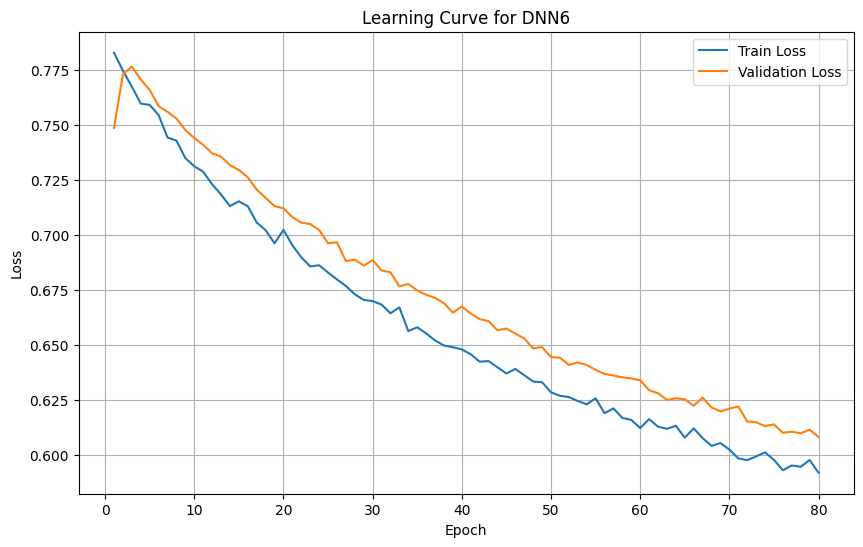

In [77]:
best_params=study.best_params
model = DNN_6(input_dim=X_train_tensor.shape[1],
              dropout1=best_params["dropout1"],
              dropout2=best_params["dropout2"],).to(device)
# 最適化と訓練を実行
optimizer = optim.Adam(model.parameters(), lr=best_params["learning_rate"],weight_decay=best_params["weight_decay"])
criterion = nn.BCELoss()

num_epochs=80
train_losses = []
val_losses = []

model.train()
for epoch in range(num_epochs):
    epoch_train_loss = 0
    epoch_val_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch.squeeze())
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}')

    if val_loader is not None:
        model.eval()  
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = model(X_val).squeeze()
                val_loss = criterion(val_outputs, y_val.squeeze())
                epoch_val_loss += val_loss.item()

        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        model.train()  

    if val_loader is not None:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    else:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
if val_losses:
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve for DNN6')
plt.legend()
plt.grid()
plt.show()

Accuracy: 57.18%
Precision: 0.4699
Recall: 0.8525
F1 Score: 0.6059
Matthews Correlation Coefficient: 0.2633
Specificity: 0.3952


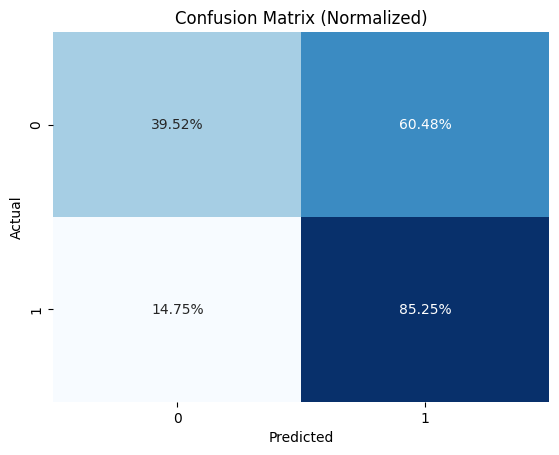

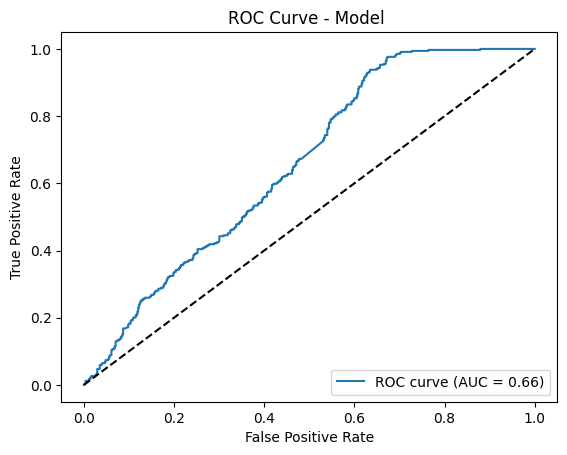

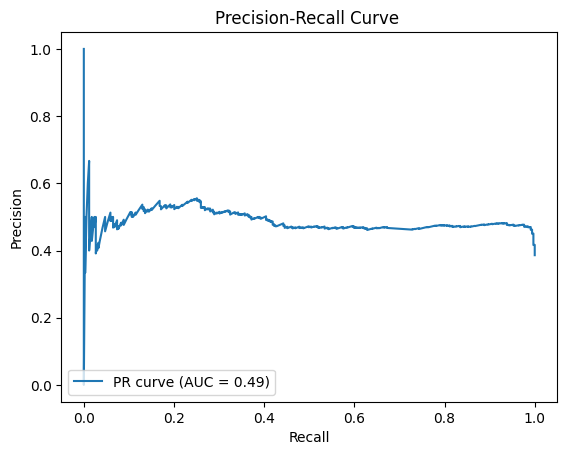

In [78]:
model.eval()
with torch.no_grad():
    X_test_tensor = X_test_tensor.to(device)
    y_test_tensor = y_test_tensor.to(device)

    # 予測と確率
    test_outputs = model(X_test_tensor).squeeze()
    predictions = (test_outputs >=0.5).float()
    y_true = y_test_tensor.cpu().numpy()
    y_pred = predictions.cpu().numpy()
    y_prob = test_outputs.cpu().numpy()

# 評価指標
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    specificity = recall_score(y_true, y_pred, pos_label=0)  
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Matthews Correlation Coefficient: {mcc:.4f}')
    print(f'Specificity: {specificity:.4f}')

    # 混同行列（割合表示）
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    sns.heatmap(cm, annot=True, fmt=".2%", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix (Normalized)")
    plt.show()

    # ROC曲線とAUC
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Model ')
    plt.legend(loc="lower right")
    plt.show()

    # Precision-Recall曲線
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(recall_curve, precision_curve)
    plt.plot(recall_curve, precision_curve, label=f'PR curve (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve ')
    plt.legend(loc="lower left")
    plt.show()    

In [ ]:
# モデルと構造を保存
torch.save(model.state_dict(), 'model_params/DNN_6.pth')




In [61]:
from torchsummary import summary
summary(model, input_size=(X_train_tensor.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]             960
       BatchNorm1d-2                   [-1, 32]              64
           Dropout-3                   [-1, 32]               0
            Linear-4                   [-1, 16]             528
       BatchNorm1d-5                   [-1, 16]              32
            Linear-6                    [-1, 8]             136
       BatchNorm1d-7                    [-1, 8]              16
           Dropout-8                    [-1, 8]               0
            Linear-9                    [-1, 4]              36
      BatchNorm1d-10                    [-1, 4]               8
           Linear-11                    [-1, 1]               5
Total params: 1,785
Trainable params: 1,785
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/back